In [11]:
# We learn how to create a graph minor on chemical structure graphs

#### initialise nb

In [12]:
%load_ext autoreload
%autoreload 2
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# get data
from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice

def get_graphs(dataset_fname='../toolsdata/bursi.pos.gspan', size=100):
    return  islice(gspan_to_eden(dataset_fname),size)

# demonstration of the proprocesor learning the abstraction

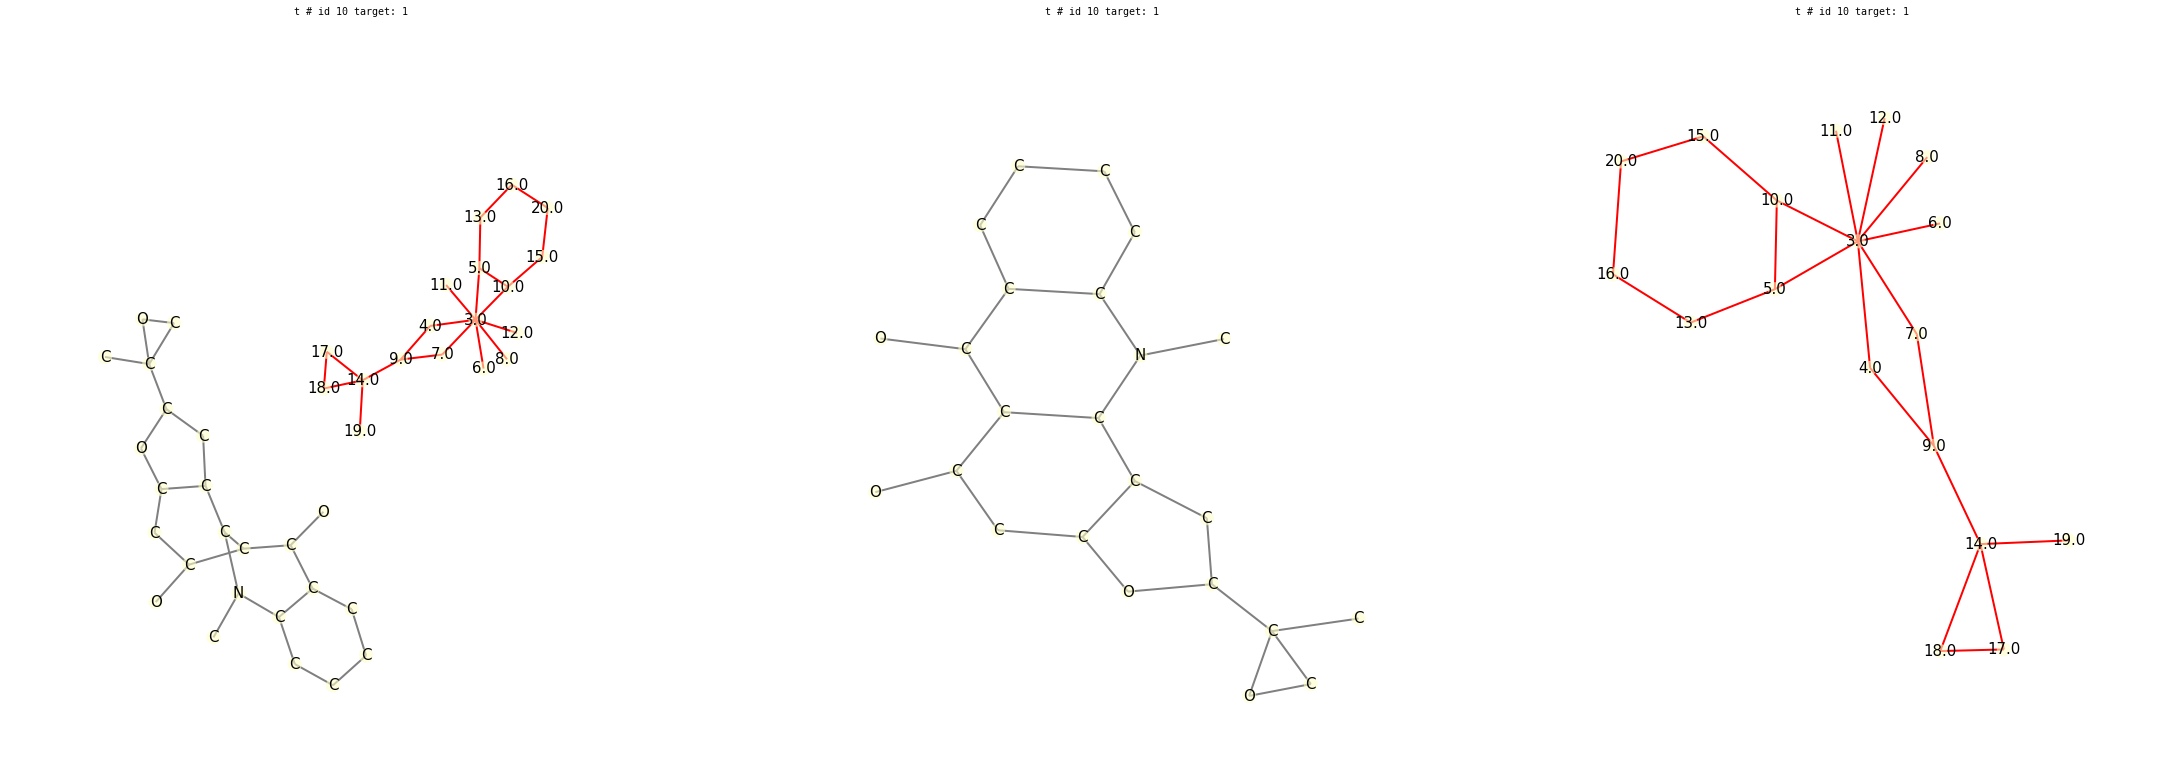

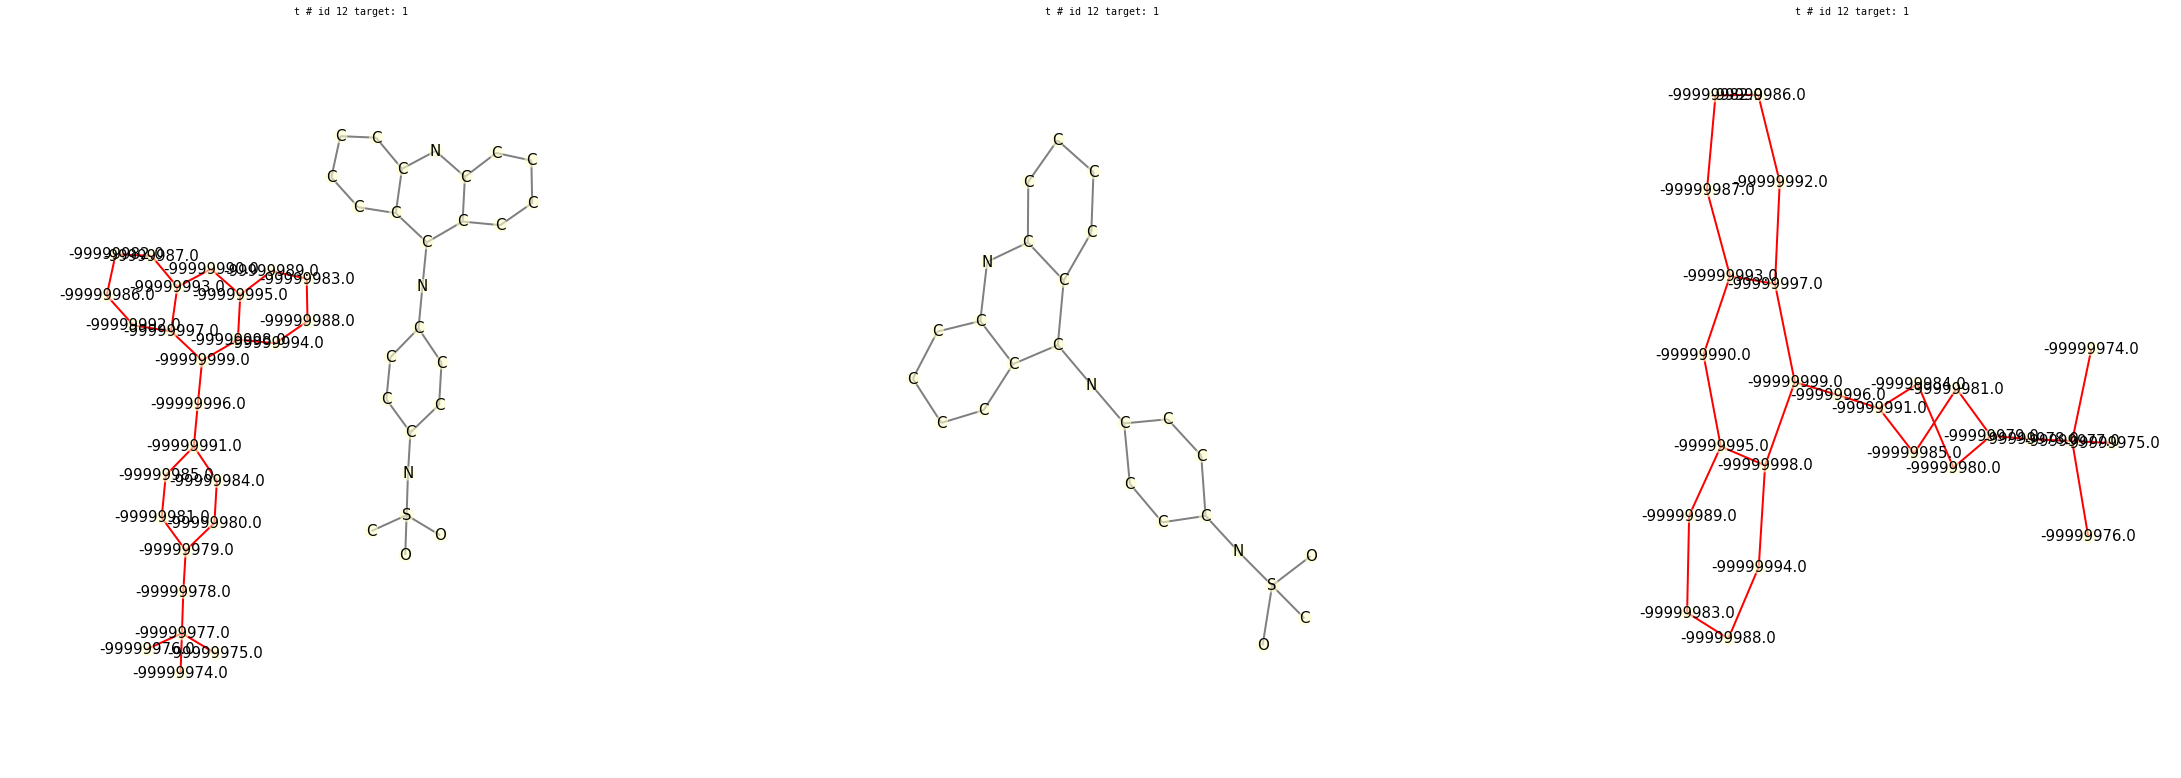

In [14]:
from graphlearn.utils import draw
import graphlearn.abstract_graphs.minortransform as transform
import graphlearn.abstract_graphs.minordecompose as decompose
from eden.graph import Vectorizer
from sklearn.cluster import KMeans
import math
#preparing
v=Vectorizer(complexity=3)
make_decomposer = lambda x,y: decompose.MinorDecomposer(x,y,
                       include_base=False,
                       base_thickness_list=[2])

class shape_cluster:
    def fit(self,li):
        pass
    def predict(self,i):
        return [math.ceil(i)]

pp=transform.GraphTransformerMinorDecomp(
                          core_shape_cluster=shape_cluster(),#KMeans(n_clusters=3),
                          name_cluster=False,
                          graph_to_minor=transform.graph_to_abstract(min_size=3,score_threshold=0,debug=False))
pp.set_param(v)

# the magic happens here
decomposers= [make_decomposer(v,x) for x in pp.fit_transform(get_graphs(size=100))]

#lets draw what we did there
for i in range(2):
    draw.graphlearn([decomposers[i+5].pre_vectorizer_graph(),decomposers[i+5].base_graph(),decomposers[i+5].abstract_graph()],
                    size=13,
                    contract=True, 
                    abstract_color='red',
                    vertex_label='label'
                   )

# lets see if these wrappers give us CIPS as this is their only purpose :)

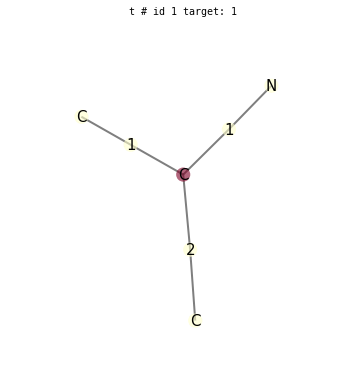

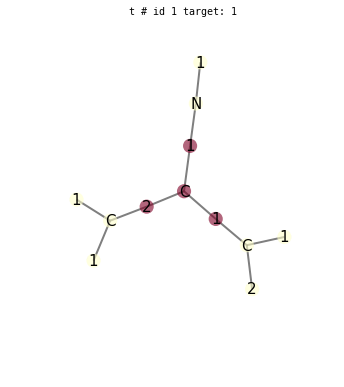

In [15]:
#parameters 
radius_list=[0,2]
thickness_list=[2,4]
base_thickness_list=[2]
#extract
cips=decomposers[0].all_core_interface_pairs(thickness_list=[2],radius_list=[0,1],hash_bitmask=2**20-1)
#draw
draw.graphlearn(cips[0][0].graph, contract=False)
draw.graphlearn(cips[0][1].graph, contract=False)

### Train sampler

In [16]:
%%time
from graphlearn.graphlearn import Sampler as GLS
graphs = get_graphs(size=200)
sampler=GLS(radius_list=[0,1],
            thickness_list=[1], 
            min_cip_count=2, 
            min_interface_count=2, 
            decomposer=make_decomposer,
            graphtransformer=transform.GraphTransformerMinorDecomp(name_cluster=False))

sampler.fit(graphs,grammar_n_jobs=1)
print 'done'

done
CPU times: user 33.8 s, sys: 1.18 s, total: 34.9 s
Wall time: 42.9 s


## Inspect the induced grammar

interface id: 427728 [26 options]


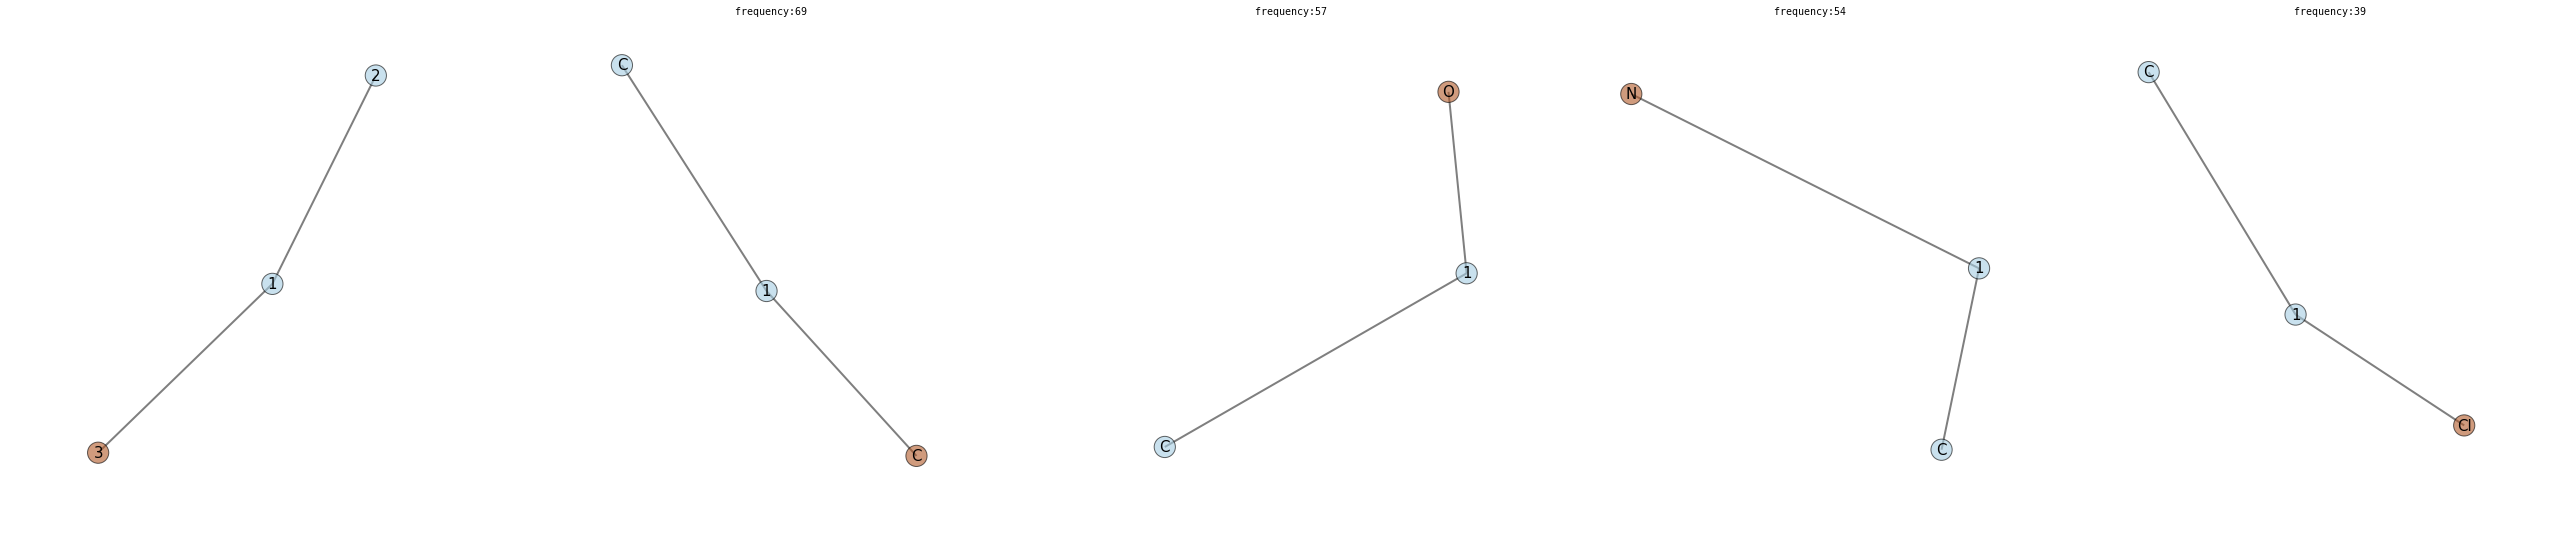

interface id: 529250 [15 options]


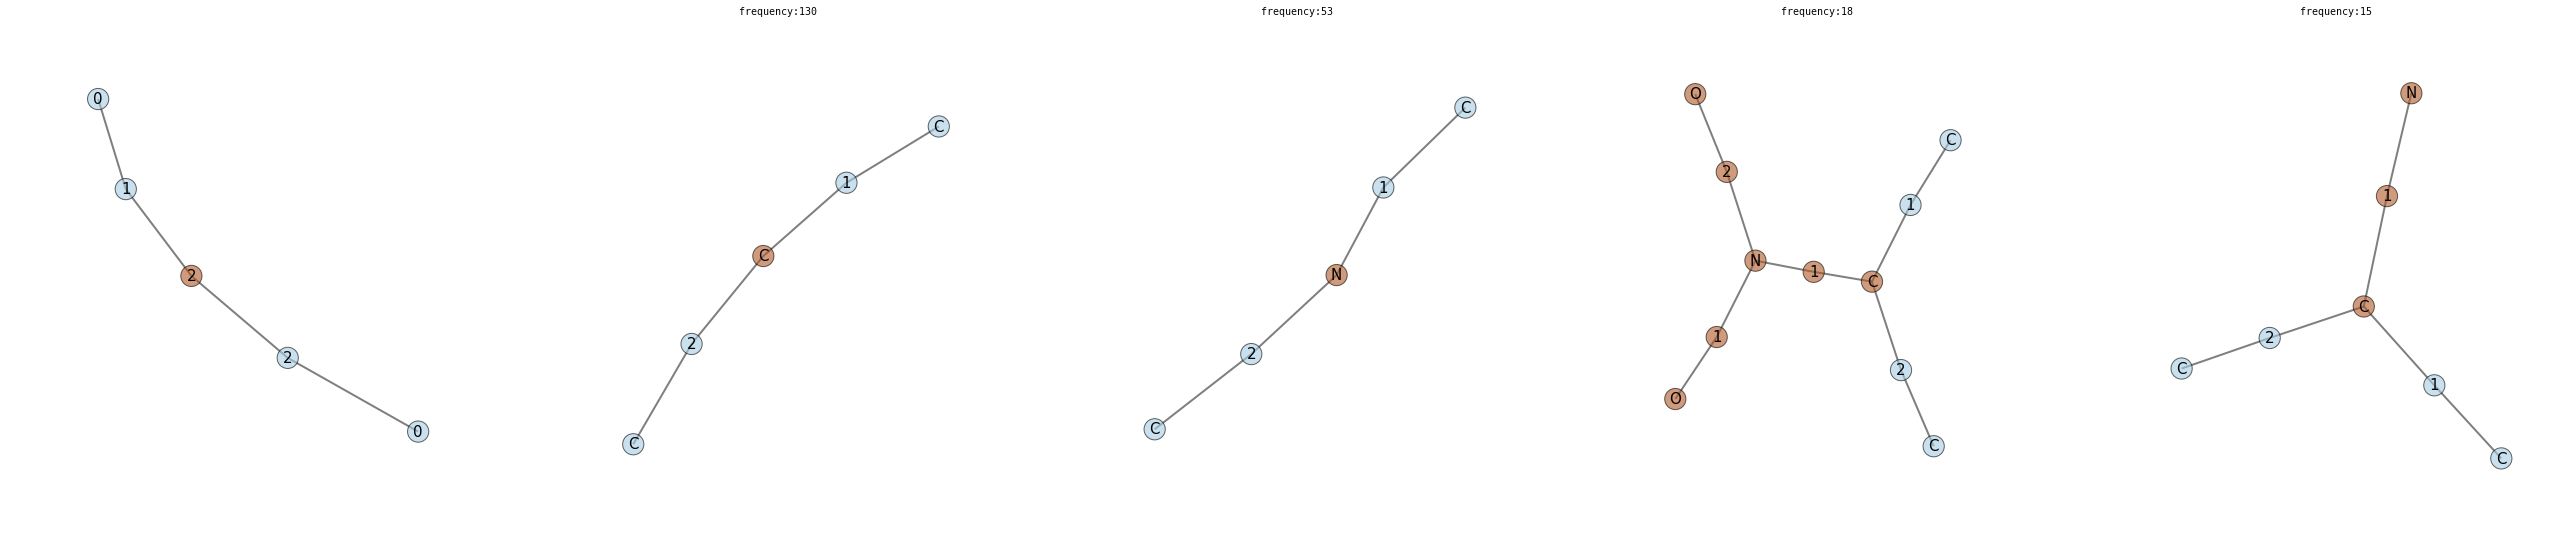

interface id: 534626 [13 options]


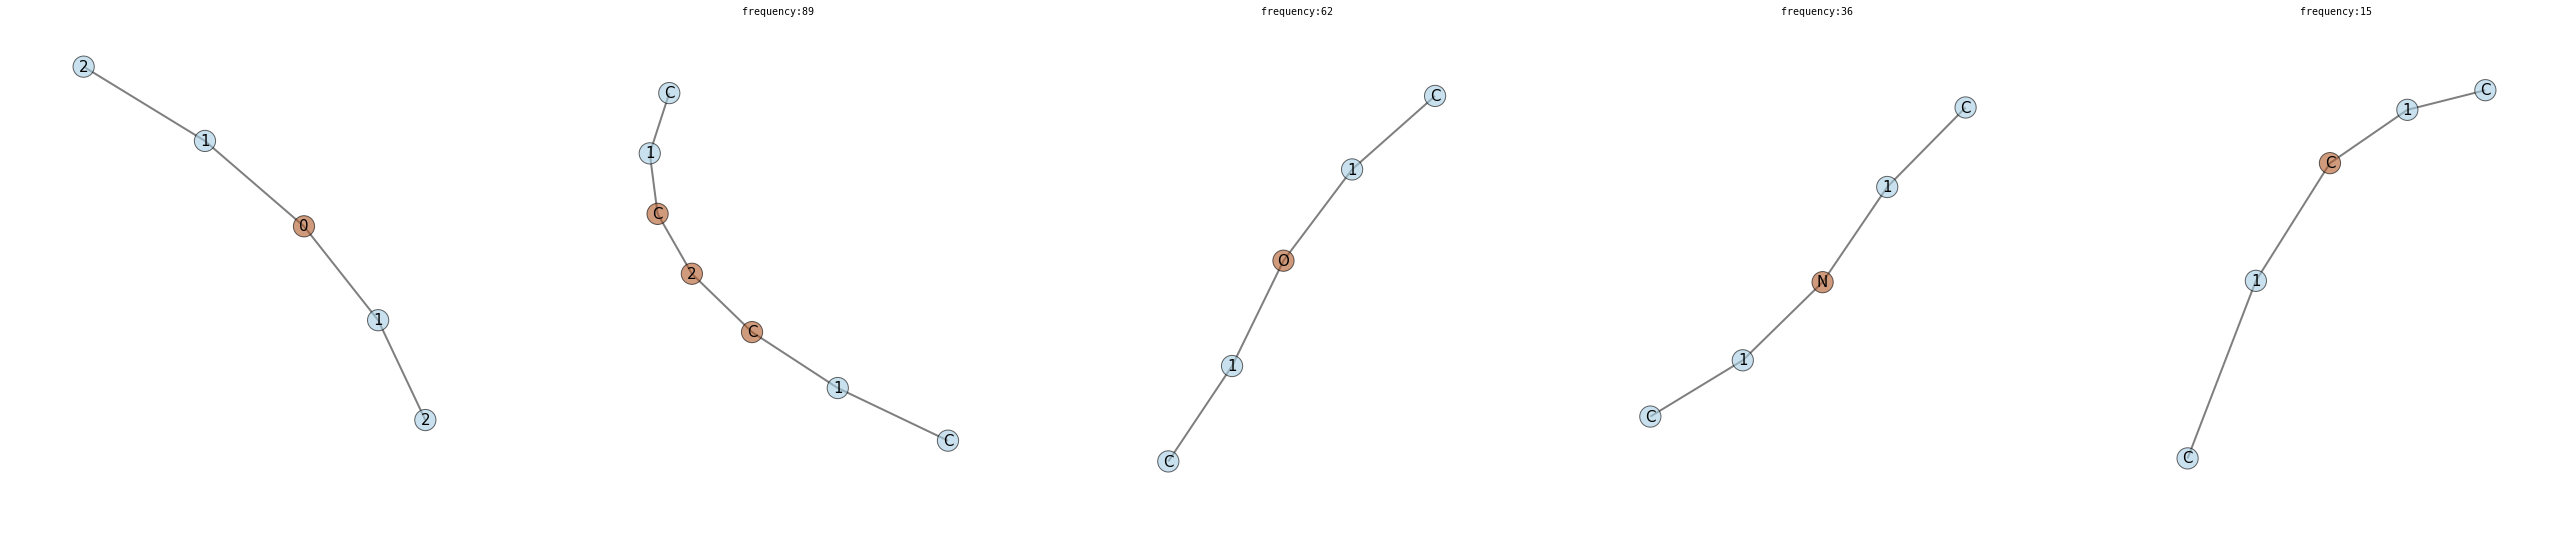

interface id: 542986 [11 options]


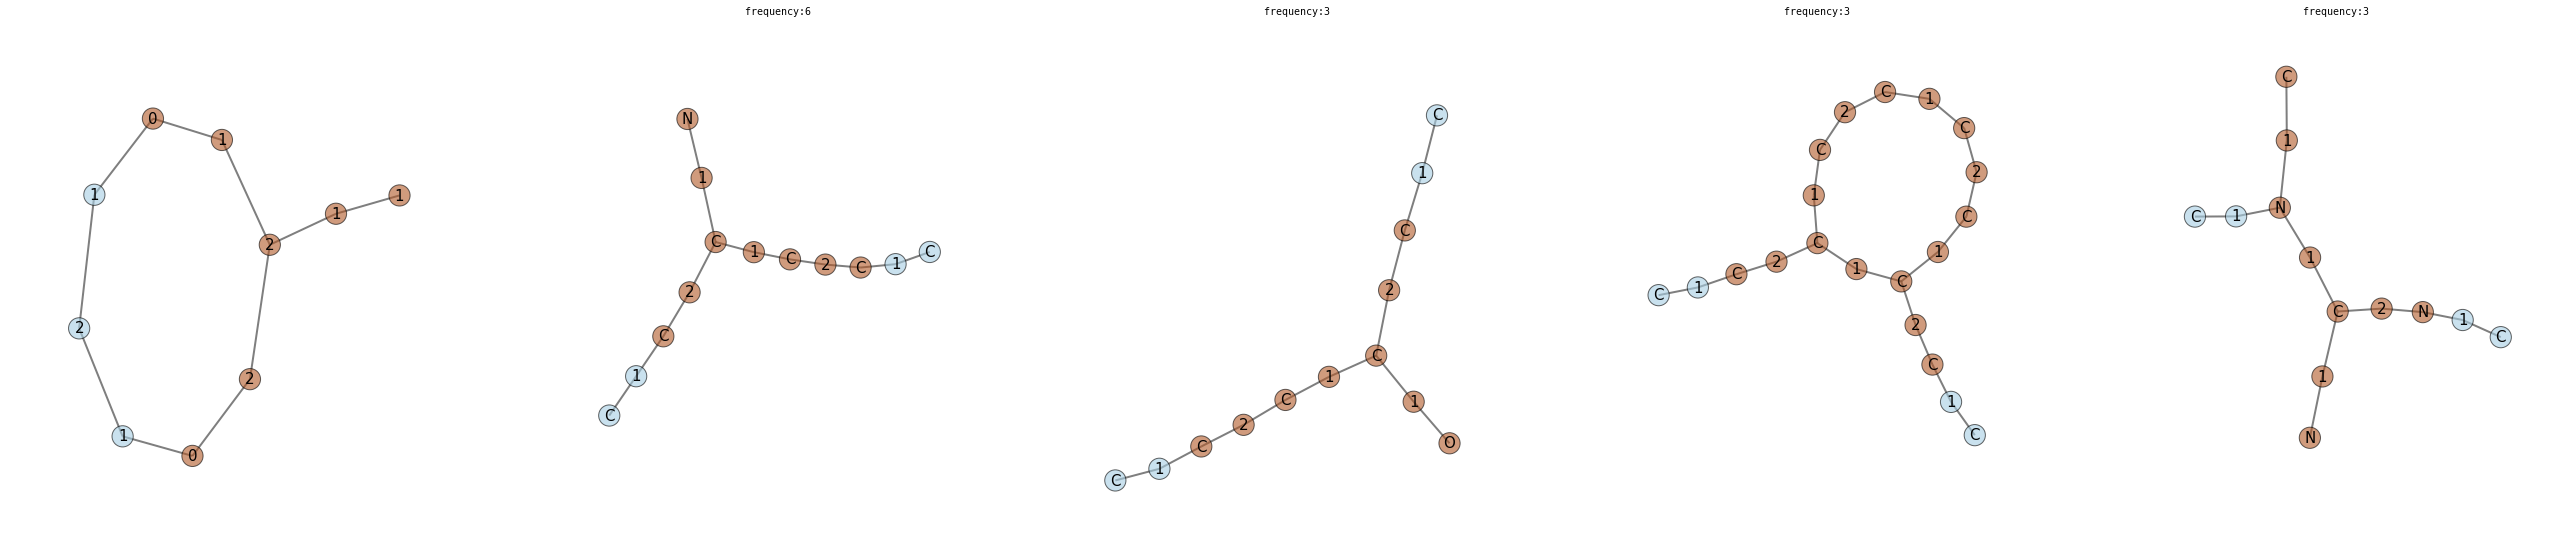

interface id: 522347 [8 options]


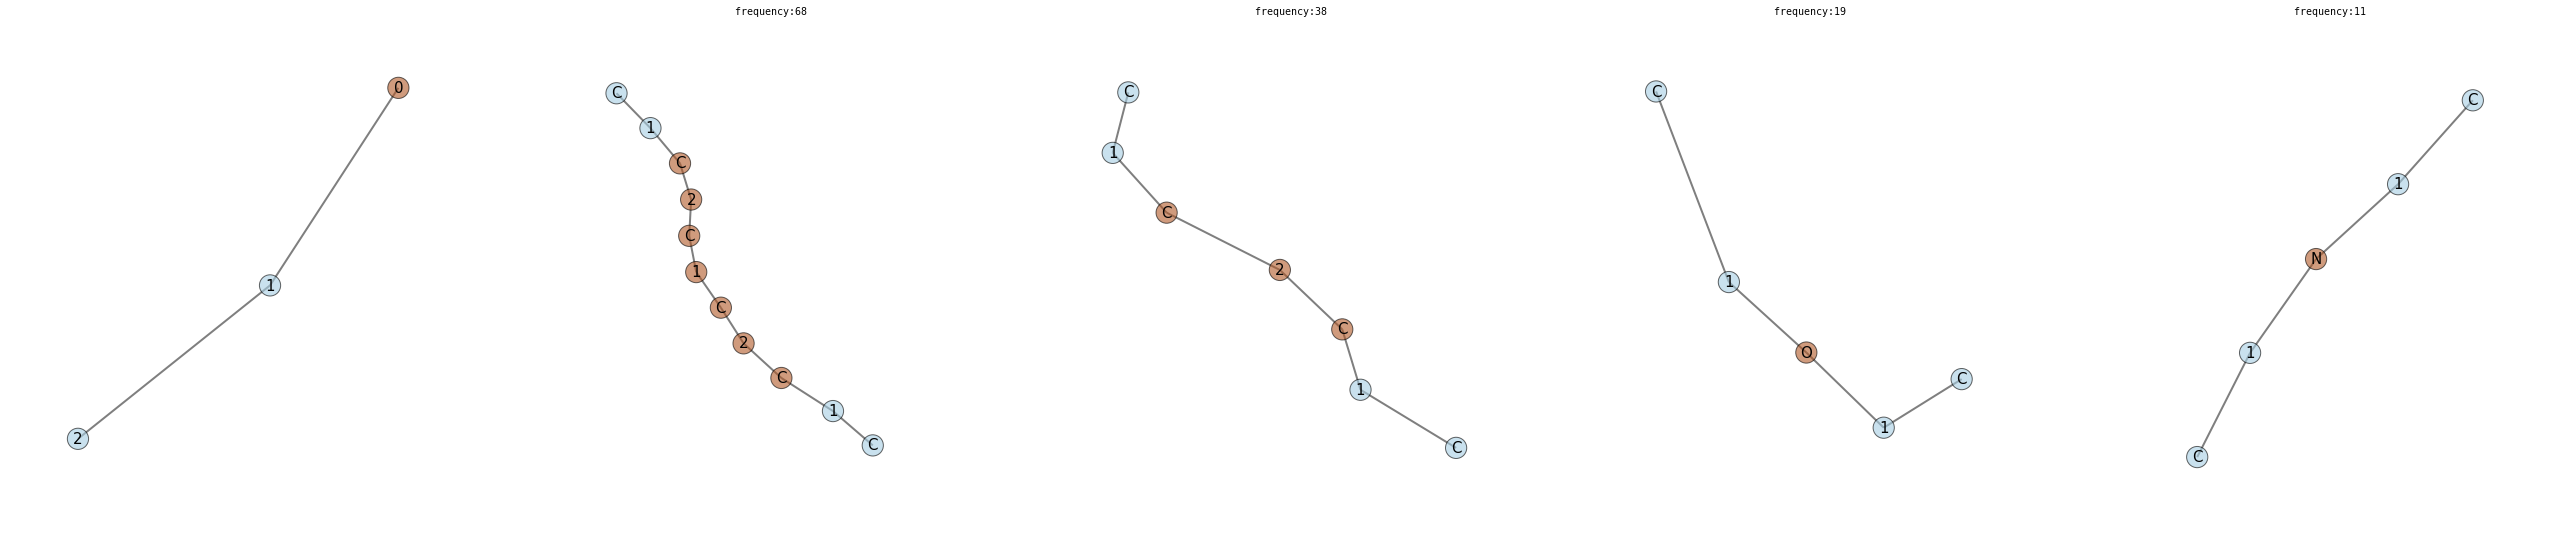

In [17]:
draw.draw_grammar(sampler.lsgg.productions,n_productions=5,n_graphs_per_production=5,
                     n_graphs_per_line=5, size=9, contract=False,
                     colormap='Paired', invert_colormap=False,node_border=1,
                     vertex_alpha=0.6, edge_alpha=0.5, node_size=450, abstract_interface=True)

## sample molecules

In [18]:
%%time
import graphlearn.utils.draw as draw
from graphlearn.utils import openbabel
import itertools

#parameters
graphs = get_graphs()
id_start=15
id_end=id_start+9
graphs = itertools.islice(graphs,id_start,id_end)
n_steps=50


# sampling with many arguments.
graphs = sampler.sample(graphs,
                        n_samples=5,
                        batch_size=1,
                        n_steps=n_steps,
                        n_jobs=1,
                        quick_skip_orig_cip=True,
                        probabilistic_core_choice=False,
                        burnin=0,
                        improving_threshold=0.5,
                        select_cip_max_tries=100,
                        keep_duplicates=True,
                        include_seed=True)

 
    
scores=[]
ids=range(id_start,id_end)
for i,path_graphs in enumerate(graphs):
    # for each sampling path:
    print 'Graph id: %d'%(ids[i])
    
    #collect scores so that we can display the score graph later 
    scores.append(sampler.monitors[i].sampling_info['score_history'])
    
    # show graphs
    openbabel.draw(path_graphs,n_graphs_per_line=5)
    #draw.graphlearn(path_graphs,
    #                       n_graphs_per_line=5, size=10, 
    #                       colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='color_level',
    #                       vertex_alpha=0.5, edge_alpha=0.7, node_size=450,edge_label='label')

Graph id: 15


Graph id: 16


Graph id: 17


Graph id: 18


Graph id: 19


Graph id: 20


Graph id: 21


Graph id: 22


Graph id: 23


CPU times: user 18.3 s, sys: 44 ms, total: 18.3 s
Wall time: 18.5 s


## plot score graph

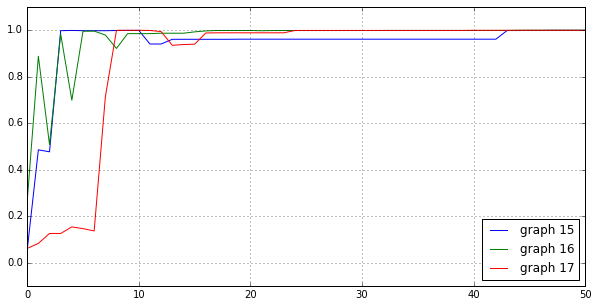

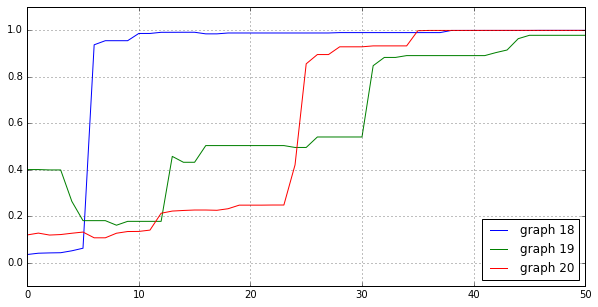

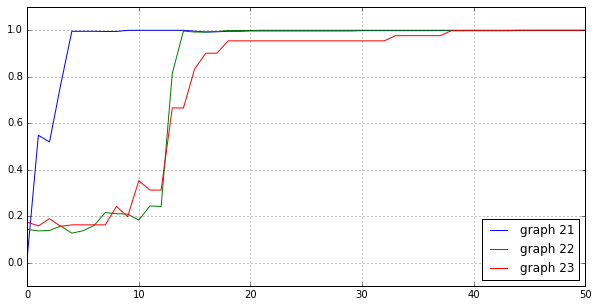

In [19]:
%matplotlib inline
from itertools import islice
import numpy as np
import matplotlib.pyplot as plt

step=1
num_graphs_per_plot=3
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):
    plt.figure(figsize=(10,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
        data = list(islice(score,None, None, step))
        plt.plot(data, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
    plt.legend(loc='lower right')
    plt.grid()
    plt.ylim(-0.1,1.1)
    plt.show()